In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import pandas as pd
import joblib

import os
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

import pathlib
DATA_DIR = pathlib.Path.cwd()/'data/input'
OUT_DIR = pathlib.Path.cwd()/'data/output'

from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.utils import resample

import lightgbm as lgb
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence

import sys 
sys.path.append(str(pathlib.Path.cwd()/'utils'))
from utils.misc_utils import fullrange, realized_volatility, log_return, rmspe, get_stock_path, load_parquet_file, load_parquet_files, load_train_test

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

In [3]:
final_training_data = pd.read_pickle(OUT_DIR/'final_training_data_finer_buckets.pkl')
final_test_data = pd.read_pickle(OUT_DIR/'final_test_data_finer_buckets.pkl')
#final_training_data = final_training_data.dropna(axis=1)

final_training_data['stock_id'] = final_training_data['stock_id'].astype(str)

In [4]:
seed = 123
model_col = [col for col in final_training_data.columns if ('id' not in col) & ('target' not in col)]

X_train, X_test, y_train, y_test = train_test_split(
                                        final_training_data.drop(['target', 'time_id', 'stock_id', 'id'], axis=1),
                                        final_training_data['target'],
                                        test_size=0.1, 
                                        random_state = seed
                                        )

X_train, X_valid, y_train, y_valid = train_test_split(
                                        X_train,
                                        y_train,
                                        test_size=0.1, 
                                        random_state = seed
                                        )


In [5]:
X_train.head()

,wap1_mean_0_100,wap1_std_0_100,wap1_fullrange_0_100,wap2_mean_0_100,wap2_std_0_100,wap2_fullrange_0_100,log_return_1_fullrange_0_100,log_return_1_sum_0_100,log_return_1_mean_0_100,log_return_1_realized_volatility_0_100,...,log_return_1_realized_volatility_std_stock_500_600,log_return_2_realized_volatility_std_stock_500_600,log_return_1_sum_std_stock_500_600,log_return_2_sum_std_stock_500_600,volume_mean_mean_stock_500_600,volume_mean_std_stock_500_600,price_mean_mean_stock_500_600,price_mean_std_stock_500_600,order_count_mean_mean_stock_500_600,order_count_mean_std_stock_500_600
271316,1.001725,0.000403,0.001460,1.001741,0.000456,0.001701,0.000776,0.001712,2.674825e-05,0.001182,...,0.002175,0.002818,0.003174,0.003249,356.697357,351.975067,0.991498,0.091635,4.209815,2.308720
351873,0.999928,0.000866,0.003023,0.999947,0.001132,0.004060,0.003445,0.000022,4.517612e-07,0.003606,...,0.001996,0.002789,0.001445,0.001521,64.007065,79.529320,0.920605,0.270373,2.627189,1.978766
230684,0.998437,0.000199,0.000869,0.998426,0.000206,0.000887,0.002935,-0.002100,-2.876219e-05,0.002717,...,0.001308,0.001920,0.001201,0.001267,176.807190,86.029465,0.999270,0.028181,2.694061,1.026069
89324,1.003039,0.000453,0.001719,1.003246,0.000489,0.001786,0.001817,0.000374,7.189600e-06,0.002023,...,0.000962,0.001300,0.001157,0.001185,176.300476,98.079056,0.995675,0.066603,2.989307,1.305914
76616,1.003473,0.001317,0.005062,1.003513,0.001385,0.005667,0.002680,0.000645,6.514517e-06,0.003403,...,0.000784,0.000985,0.001191,0.001219,518.188843,451.768707,0.990416,0.097902,4.918474,2.964929


In [6]:
final_training_data.shape

(428932, 364)

## Model Training 

In [7]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
rmspe(y_test, xgb.predict(X_test))

0.23771456475174454

In [8]:
import numpy as np
import lightgbm as lgb

def rmspe_obj(
    prediction,
    train
    ):
    y = train.get_label()
    grad = -2*(y-prediction)/(y**2)
    hess = 2/(y**2)
    return grad, hess

def rmspe_eval(
    prediction,
    train
    ):
    y = train.get_label()
    rmspe =  (np.sqrt(np.mean(np.square((y - prediction) / y))))
    return 'rmspe', rmspe, False

In [9]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)
test_data = lgb.Dataset(X_test, label=y_test)


parameters = {'verbosity': -1,
                'n_jobs': -1,
                'seed': 123}

model = lgb.train(parameters,
                       train_data,
                       valid_sets=valid_data,
                       fobj = rmspe_obj,
                       feval = rmspe_eval,
                       num_boost_round=50000,
                       early_stopping_rounds=200)

rmspe(y_test, model.predict(X_test))

[1]	valid_0's rmspe: 0.908037
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmspe: 0.825791
[3]	valid_0's rmspe: 0.752365
[4]	valid_0's rmspe: 0.686855
[5]	valid_0's rmspe: 0.628818
[6]	valid_0's rmspe: 0.577167
[7]	valid_0's rmspe: 0.531524
[8]	valid_0's rmspe: 0.491297
[9]	valid_0's rmspe: 0.455693
[10]	valid_0's rmspe: 0.424365
[11]	valid_0's rmspe: 0.397161
[12]	valid_0's rmspe: 0.373689
[13]	valid_0's rmspe: 0.353018
[14]	valid_0's rmspe: 0.334817
[15]	valid_0's rmspe: 0.319393
[16]	valid_0's rmspe: 0.306343
[17]	valid_0's rmspe: 0.294807
[18]	valid_0's rmspe: 0.285024
[19]	valid_0's rmspe: 0.276671
[20]	valid_0's rmspe: 0.269477
[21]	valid_0's rmspe: 0.263283
[22]	valid_0's rmspe: 0.257843
[23]	valid_0's rmspe: 0.253356
[24]	valid_0's rmspe: 0.249513
[25]	valid_0's rmspe: 0.246053
[26]	valid_0's rmspe: 0.243321
[27]	valid_0's rmspe: 0.240934
[28]	valid_0's rmspe: 0.238874
[29]	valid_0's rmspe: 0.236781
[30]	valid_0's rmspe: 0.235037
[31]	valid_0's rm

0.2001009272642293

## Feature Importance

In [10]:
import shap
shap.initjs()

In [11]:
explainer_lgbm = shap.KernelExplainer(model.predict, shap.sample(X_test, 100))
shap_values_lgbm = explainer_lgbm.shap_values(shap.sample(X_test, 100), nsamples=500)

100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


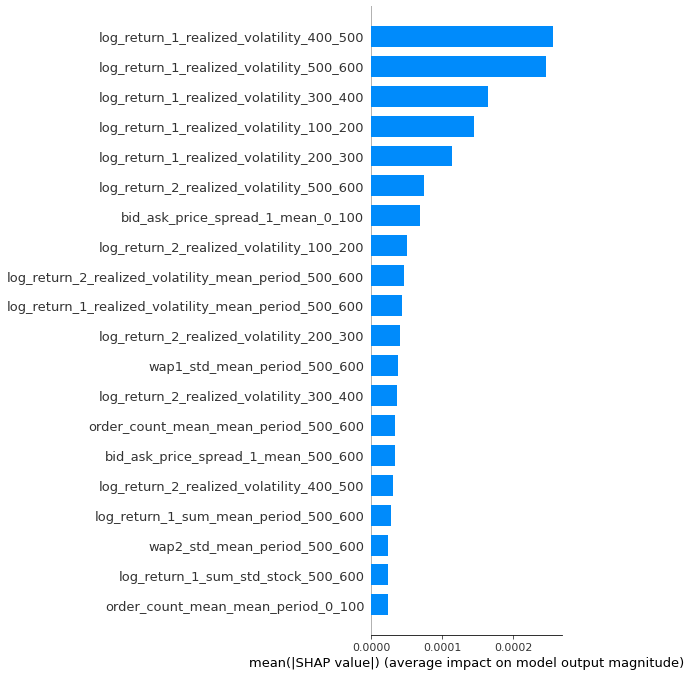

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values_lgbm, shap.sample(X_test, 100), plot_type="bar", auto_size_plot=False, show=False)
plt.tight_layout()

In [13]:
vals= np.abs(shap_values_lgbm).mean(0)

feature_importance = pd.DataFrame(list(zip(X_test.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

In [14]:
X_train

,wap1_mean_0_100,wap1_std_0_100,wap1_fullrange_0_100,wap2_mean_0_100,wap2_std_0_100,wap2_fullrange_0_100,log_return_1_fullrange_0_100,log_return_1_sum_0_100,log_return_1_mean_0_100,log_return_1_realized_volatility_0_100,...,log_return_1_realized_volatility_std_stock_500_600,log_return_2_realized_volatility_std_stock_500_600,log_return_1_sum_std_stock_500_600,log_return_2_sum_std_stock_500_600,volume_mean_mean_stock_500_600,volume_mean_std_stock_500_600,price_mean_mean_stock_500_600,price_mean_std_stock_500_600,order_count_mean_mean_stock_500_600,order_count_mean_std_stock_500_600
271316,1.001725,0.000403,0.001460,1.001741,0.000456,0.001701,0.000776,0.001712,2.674825e-05,0.001182,...,0.002175,0.002818,0.003174,0.003249,356.697357,351.975067,0.991498,0.091635,4.209815,2.308720
351873,0.999928,0.000866,0.003023,0.999947,0.001132,0.004060,0.003445,0.000022,4.517612e-07,0.003606,...,0.001996,0.002789,0.001445,0.001521,64.007065,79.529320,0.920605,0.270373,2.627189,1.978766
230684,0.998437,0.000199,0.000869,0.998426,0.000206,0.000887,0.002935,-0.002100,-2.876219e-05,0.002717,...,0.001308,0.001920,0.001201,0.001267,176.807190,86.029465,0.999270,0.028181,2.694061,1.026069
89324,1.003039,0.000453,0.001719,1.003246,0.000489,0.001786,0.001817,0.000374,7.189600e-06,0.002023,...,0.000962,0.001300,0.001157,0.001185,176.300476,98.079056,0.995675,0.066603,2.989307,1.305914
76616,1.003473,0.001317,0.005062,1.003513,0.001385,0.005667,0.002680,0.000645,6.514517e-06,0.003403,...,0.000784,0.000985,0.001191,0.001219,518.188843,451.768707,0.990416,0.097902,4.918474,2.964929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197045,0.999948,0.000123,0.000470,0.999936,0.000177,0.000575,0.004601,-0.004847,-1.731091e-04,0.004530,...,0.001333,0.001838,0.001347,0.001420,180.541718,125.051971,0.995214,0.068498,3.426942,1.699044
184716,1.004577,0.000860,0.003405,1.004539,0.000956,0.004066,0.002854,0.002408,3.490331e-05,0.004245,...,0.000880,0.001241,0.000896,0.000955,135.849884,78.654083,0.999246,0.028087,3.589021,1.622514
415917,1.000384,0.000128,0.000504,1.000333,0.000123,0.000345,0.002131,-0.002479,-2.723951e-05,0.002038,...,0.000837,0.001023,0.001230,0.001234,262.753235,142.416275,0.999696,0.016511,3.669063,1.429362
357714,1.000366,0.002857,0.012678,1.000312,0.003421,0.015252,0.011918,-0.000248,-4.432438e-06,0.015389,...,0.000898,0.001155,0.001199,0.001243,300.436829,201.582870,0.992235,0.088256,3.822708,1.863821


In [15]:
num_features = 30
selected_features = list(feature_importance.col_name)[:num_features]
X_train_shap, X_valid_shap, X_test_shap = X_train[selected_features], X_valid[selected_features], X_test[selected_features]

train_data_shap = lgb.Dataset(X_train_shap, label=y_train)
valid_data_shap = lgb.Dataset(X_valid_shap, label=y_valid)
test_data_shap = lgb.Dataset(X_test_shap, label=y_test)


parameters = {'verbosity': -1,
              'n_jobs': -1,
              'seed': 123
              }

model = lgb.train(parameters,
                       train_data_shap,
                       valid_sets=valid_data_shap,
                       fobj = rmspe_obj,
                       feval = rmspe_eval,
                       num_boost_round=50000,
                       early_stopping_rounds=200,
                       verbose_eval=0
                       )

rmspe(y_test, model.predict(X_test_shap))

0.20056340727167857

### LOFO Importance

In [16]:
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.metrics import make_scorer

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)


100%|██████████| 360/360 [08:43<00:00,  1.46s/it]


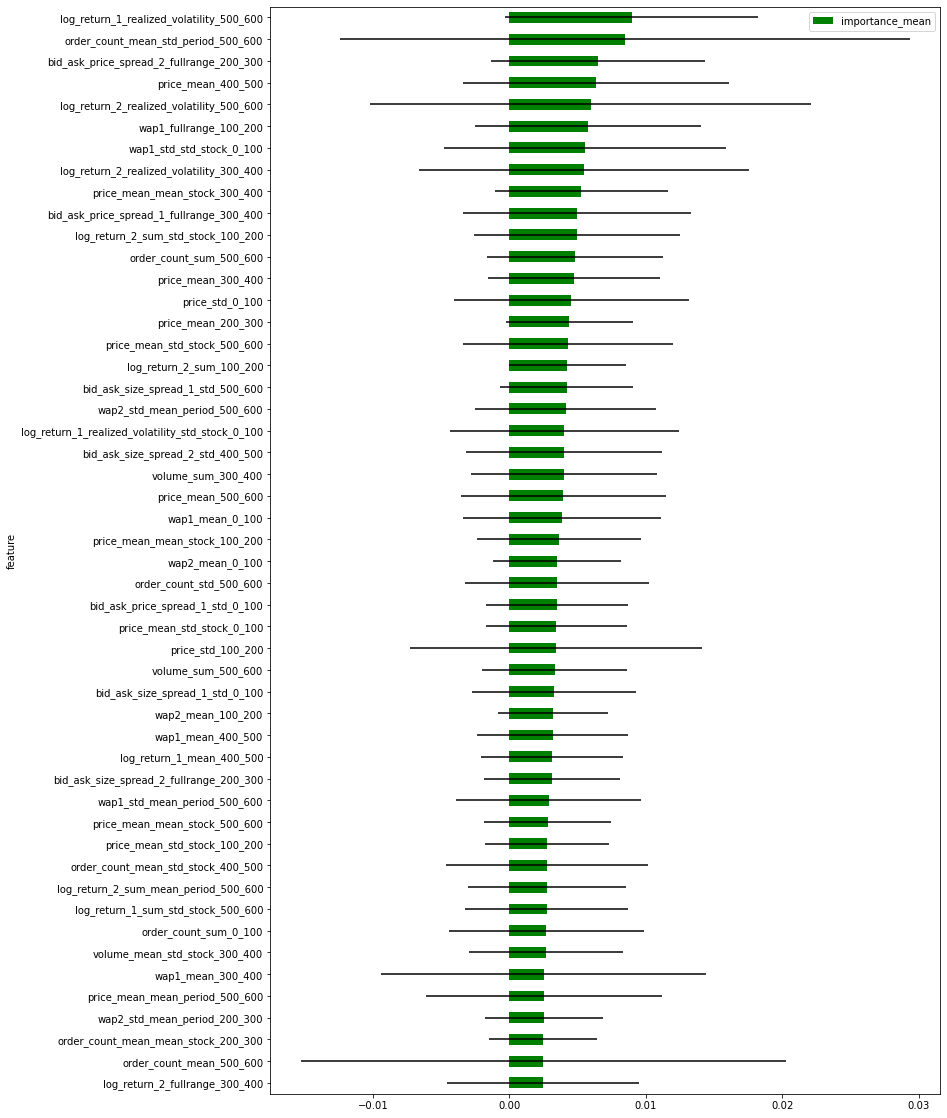

In [17]:
# extract a sample of the data
sample_df = X_test.copy() 
sample_df['target'] = y_test
sample_df = sample_df.sample(frac=0.01, random_state=0)
cv = KFold(n_splits=4, shuffle=True, random_state=0)
# define the binary target and the features
dataset = Dataset(df=sample_df, target="target", features=[col for col in sample_df.columns if col != 'target'])
# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring=rmspe_scorer)
# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()
# plot the means and standard deviations of the importances
plot_importance(importance_df[:50], figsize=(12, 20))
plt.savefig('Importance Plot.png')

In [18]:
selected_lofo_features = importance_df.loc[importance_df.importance_mean>0.001]['feature'].to_list()
X_train_lofo, X_valid_lofo, X_test_lofo = X_train[selected_lofo_features], X_valid[selected_lofo_features], X_test[selected_lofo_features]

train_data_lofo = lgb.Dataset(X_train_lofo, label=y_train)
valid_data_lofo = lgb.Dataset(X_valid_lofo, label=y_valid)
test_data_lofo = lgb.Dataset(X_test_lofo, label=y_test)

parameters = {'verbosity': -1,
                'n_jobs': -1,
                'seed': 123}

model = lgb.train(parameters,
                       train_data_lofo,
                       valid_sets=valid_data_lofo,
                       fobj = rmspe_obj,
                       feval = rmspe_eval,
                       num_boost_round=50000,
                       early_stopping_rounds=200,
                       verbose_eval=0
                       )

rmspe(y_test, model.predict(X_test_lofo))

0.21594037076997602

In [19]:
submission = final_test_data[['id']].rename(columns = {'id': 'row_id'})
submission['target'] = model.predict(final_test_data[selected_lofo_features])

## Evaluation by Stocks

In [20]:
model.predict(X_test_lofo)

array([0.00350577, 0.00629634, 0.00108152, ..., 0.00398725, 0.00719375,
       0.00224486])

In [21]:
stock_index_dict = final_training_data.reset_index().groupby('stock_id')['index'].apply(list).to_dict()

In [22]:
score_dict_by_stock = {} 
for key in stock_index_dict.keys(): 
    mask = X_test_lofo.index.isin(stock_index_dict[key])
    score_dict_by_stock[key] = rmspe(y_test[mask], model.predict(X_test_lofo[mask]))

In [23]:
score_dict_by_stock

{'0': 0.23959288796154773,
 '1': 0.17842097225707357,
 '10': 0.15787568561292392,
 '100': 0.19224470711988498,
 '101': 0.17889417700294918,
 '102': 0.18941787868991924,
 '103': 0.24983964989422291,
 '104': 0.1879406811400253,
 '105': 0.18565966394763453,
 '107': 0.1891129113749882,
 '108': 0.2013705952307996,
 '109': 0.163895511875975,
 '11': 0.21496908977371013,
 '110': 0.25746040797280795,
 '111': 0.1802149882426088,
 '112': 0.2477649385431277,
 '113': 0.17385921459678053,
 '114': 0.18346746951379983,
 '115': 0.19460032184448092,
 '116': 0.22932198569918183,
 '118': 0.19374089661767452,
 '119': 0.16965153607439631,
 '120': 0.15869144085646314,
 '122': 0.181696202302245,
 '123': 0.1703149908791564,
 '124': 0.14564546864526295,
 '125': 0.1734971540190875,
 '126': 0.21643725131452998,
 '13': 0.17562684478212068,
 '14': 0.14333767839970177,
 '15': 0.18135466582457577,
 '16': 0.2477088151804221,
 '17': 0.1662918919166795,
 '18': 0.283338672547997,
 '19': 0.21328686823522303,
 '2': 0.17060

## Hyperparameter Tuning with Optuna

In [11]:
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold
from utils.hyperparameter_tune import lightgbm_optuna_objective
from utils.misc_utils import rmspe_eval, rmspe_obj, rmspe


In [12]:
seed = 123
X = final_training_data.drop(['target', 'time_id', 'stock_id', 'id'], axis=1)
y = final_training_data['target']

cv = KFold(n_splits=5, random_state=seed, shuffle=True)

fixed_params = parameters = {
    'verbosity': -1,
    'n_jobs': -1,
    'seed': 123, 
    'metric': 'rmse'
    }

def objective(
    trial, 
    X = final_training_data.drop(['target', 'time_id', 'stock_id', 'id'], axis=1), 
    y = final_training_data['target'], 
    fixed_params=fixed_params, 
    cv=cv
    ):
    
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 15000, 25000, step=2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 8, 4088, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 14),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 500, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 10),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 10),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95),
        **fixed_params
    }

    pruning = LightGBMPruningCallback(trial, "rmse", valid_name='valid_1')
    cv_score_rmspe = [] 

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y[train_idx], y[test_idx]

        train_data_cv = lgb.Dataset(X_train, label=y_train)
        valid_data_cv = lgb.Dataset(X_valid, label=y_valid)
        
        model =  lgb.train(param_grid,
            train_set=train_data_cv,
            valid_sets=[train_data_cv, valid_data_cv],
            early_stopping_rounds=100,
            verbose_eval=0,   
            fobj = rmspe_obj,
            feval = rmspe_eval,
            callbacks=[pruning]
        )
        predictions = model.predict(X_valid)
        cv_score_rmspe.append(rmspe(predictions, y_valid))

    return np.mean(cv_score_rmspe)

In [7]:
import functools

optuna_obj = functools.partial(
    lightgbm_optuna_objective,
    X = final_training_data.drop(['target', 'time_id', 'stock_id', 'id'], axis=1), 
    y = final_training_data['target']
    )

In [13]:
X = final_training_data.drop(['target', 'time_id', 'stock_id', 'id'], axis=1), 
y = final_training_data['target']

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=25))
study.optimize(
    objective,
    timeout=180
    )

[I 2021-09-23 22:05:42,864] A new study created in memory with name: no-name-0cacbc03-3e41-4a23-b387-142b81f6dd0d
C:\Users\twongsan\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\twongsan\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\twongsan\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\twongsan\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\twongsan\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becau

In [14]:
X = final_training_data.drop(['target', 'time_id', 'stock_id', 'id'], axis=1), 
y = final_training_data['target']

study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=25))
study.optimize(
    optuna_obj,
    timeout=180
    )

[I 2021-09-23 22:19:01,695] A new study created in memory with name: no-name-c647a696-c268-4551-af88-5c1ad05ccbcc
C:\Users\twongsan\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\twongsan\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\twongsan\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\twongsan\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\twongsan\Anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored becau

In [32]:
new_params ={
    **study.best_params, 
    **parameters
}

In [33]:
new_params

{'n_estimators': 15000,
 'learning_rate': 0.24701478508821506,
 'num_leaves': 1128,
 'max_depth': 6,
 'min_data_in_leaf': 300,
 'lambda_l1': 4,
 'lambda_l2': 5,
 'bagging_fraction': 0.8137111364239731,
 'feature_fraction': 0.591387595192254,
 'verbosity': -1,
 'n_jobs': -1,
 'seed': 123,
 'metric': 'rmse'}

In [34]:
model_tuned =  lgb.train(params = new_params,
    train_set= train_data,
    valid_sets= [train_data, valid_data],
    early_stopping_rounds=100,
    verbose_eval=1,
    fobj = rmspe_obj,
    feval = rmspe_eval,
)

Found `n_estimators` in params. Will use it instead of argument


[1]	training's rmse: 0.00394741	training's rmspe: 0.774129	valid_1's rmse: 0.00400062	valid_1's rmspe: 0.774256
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 0.00325364	training's rmspe: 0.606754	valid_1's rmse: 0.00330507	valid_1's rmspe: 0.607107
[3]	training's rmse: 0.00274085	training's rmspe: 0.485353	valid_1's rmse: 0.00278974	valid_1's rmspe: 0.485852
[4]	training's rmse: 0.00236361	training's rmspe: 0.399221	valid_1's rmse: 0.00241235	valid_1's rmspe: 0.400164
[5]	training's rmse: 0.00209475	training's rmspe: 0.339498	valid_1's rmse: 0.00214235	valid_1's rmspe: 0.341086
[6]	training's rmse: 0.00189422	training's rmspe: 0.29905	valid_1's rmse: 0.00194324	valid_1's rmspe: 0.301179
[7]	training's rmse: 0.0017476	training's rmspe: 0.272494	valid_1's rmse: 0.00179646	valid_1's rmspe: 0.274934
[8]	training's rmse: 0.00163427	training's rmspe: 0.254774	valid_1's rmse: 0.00168306	valid_1's rmspe: 0.257539
[9]	training's rmse: 0.00154402	training's r